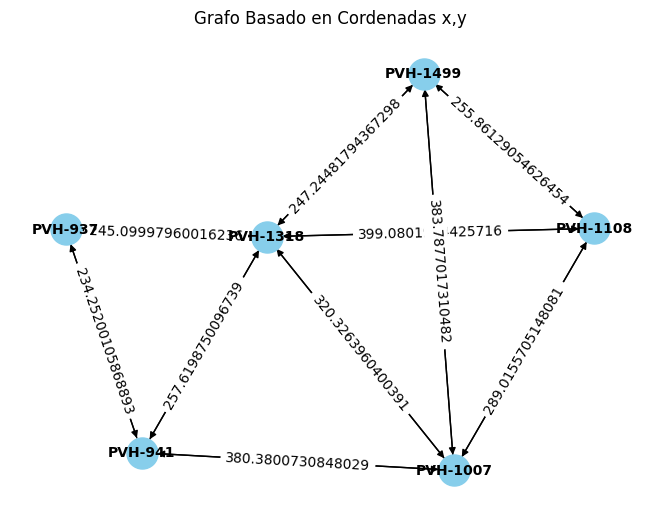

In [1]:
from graph_setup import G
from calc_functions import profiles_comparison, optimal_window, windows_test, calc_tops

In [ ]:
node_name1 = "PVH-937"
node_name2 = "PVH-1318"

data1 = G.nodes[node_name1]["data"].copy()
data2 = G.nodes[node_name2]["data"].copy()
tops1 = G.nodes[node_name1]["known_tops"].copy()

profiles_comparison(data1, data2, tops1, name1=node_name1, name2=node_name2)

Now that everything works, I need to find the optimal windows so that windows_test returns minimal error, I think I will just be looking at mae right now

In [ ]:
node_name1 = "PVH-937"
node_name2 = "PVH-1318"
bounds = [(900, 1200), (1800, 2000), (900, 1200), (1800, 2000)]

opt, error = optimal_window(G, node_name1, node_name2, bounds)

print(f"Optimal windows: {opt}")
print(f"Minimum mse: {error}")


In [ ]:
windows_test(G, node_name1, node_name2, opt, show_plots=True)

Now that we have found the optimal window, we can expand to the rest of the graph

In [ ]:
start_node = node_name2
bound1 = opt[2]
bound2 = opt[3]
w = [bound1, bound2, bound1, bound2]

new_node = "PVH-1007"
calc_tops(G, start_node, new_node, window=w)
windows_test(G, start_node, new_node, w, show_plots=True)



In [ ]:
start_node = "PVH-1007"
bound1 = opt[2]
bound2 = opt[3]
w = [bound1, bound2, bound1, bound2]

new_node = "PVH-1108"
calc_tops(G, start_node, new_node, window=w)
windows_test(G, start_node, new_node, w, show_plots=True)


Disastrous results, need to train algorithm to find correct window

In [ ]:
# This function will take several minutes to run
from solve_functions import train_window

t = ["PVH-1499", "PVH-1318", "PVH-1007" ]
train_window(G, t)


In [ ]:
windows_test(G, "PVH-1007", "PVH-1499", w , show_plots=True)

Conclusion: window optimization is definitely necessary despite the time complexity

In [ ]:
from solve_functions import calc_tops_shortest_jumps, calc_tops_dijkstra
from calc_functions import clear_tops

# window will be derived from the train_window method
win = [1400, 1900, 1400, 1900]
start_node = "PVH-941"
end_node = "PVH-1499"

#calc_tops_dijkstra(G, start_node, end_node, win)
p = calc_tops_shortest_jumps(G, start_node, end_node, win, show_plots = True)
for node in p:
    clear_tops(G, node)

    